In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib notebook
from main import *

In [2]:
#Extracting the SS coverages previously saved and extracted from kMC files
ss_COVG_NONLAT = pd.read_csv('SS_Covg_nonLat.csv')
ss_COVG_LAT = pd.read_csv('SS_Covg_Lat.csv')

In [3]:
#Isolating pressures and ss coverages
Prs_non_lat = ss_COVG_NONLAT.iloc[:,0].to_numpy()
Prs_lat = ss_COVG_LAT.iloc[:,0].to_numpy()
ss_covg_non_lat = ss_COVG_NONLAT.iloc[:,1].to_numpy()
ss_covg_lat = ss_COVG_LAT.iloc[:,1].to_numpy()

In [4]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [5]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 2.73 s, sys: 17.2 ms, total: 2.75 s
Wall time: 3.89 s


<IPython.core.display.Javascript object>


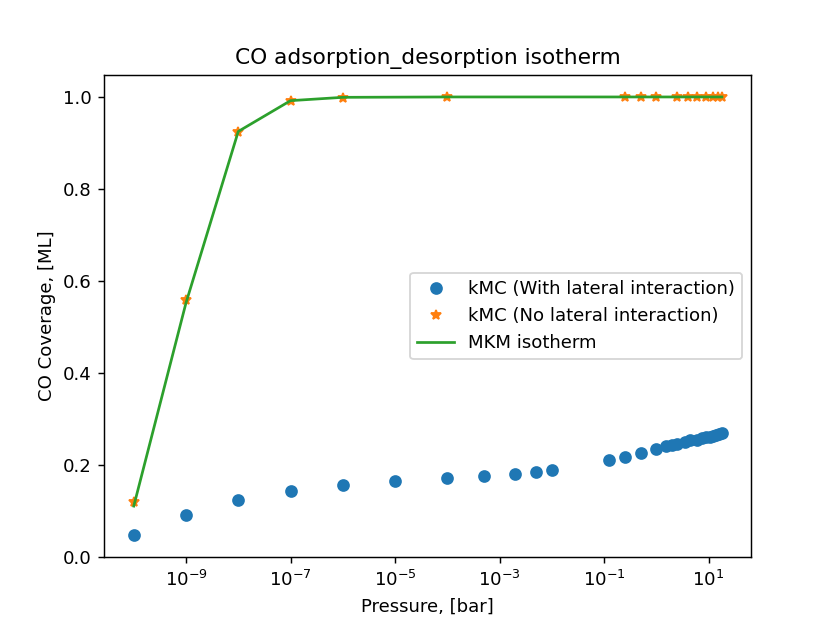

In [6]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

In [7]:
# For lateral only
##Step 1: Calculating Ki based on isotherm equation
Ki_lateral = []
for i in np.arange(len(Prs_lat)):
    Ki_lateral.append(ss_covg_lat[i]/((1-ss_covg_lat[i]) * Prs_lat[i]))
    
##Step 2: Calculating fi(theta)
Keq = MKM.k[0]/MKM.k[1]
fi_theta = []
for i in np.arange(len(Prs_lat)):
    fi_theta.append(Ki_lateral[i]/Keq)
    
##Therefore need to train ML model (for lateral interactions considered) where x is theta and y is fi_theta
##Step 3: MLM model
print('For Lateral:\n')
print('Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)')
print(np.array([Prs_lat,ss_covg_lat,Ki_lateral,fi_theta]).T)

For Lateral:

Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)
[[1.00000000e-10 4.63296155e-02 4.85803232e+08 3.94275087e-01]
 [1.00000000e-09 9.11109711e-02 1.00244329e+08 8.13577165e-02]
 [1.00000000e-08 1.21996393e-01 1.38947485e+07 1.12768973e-02]
 [1.00000000e-07 1.43216148e-01 1.67155517e+06 1.35662448e-03]
 [1.00000000e-06 1.55425457e-01 1.84028110e+05 1.49356148e-04]
 [1.00000000e-05 1.63325156e-01 1.95207442e+04 1.58429228e-05]
 [1.00000000e-04 1.70388884e-01 2.05384042e+03 1.66688498e-06]
 [5.00000000e-04 1.75406734e-01 4.25438192e+02 3.45283170e-07]
 [2.00000000e-03 1.80016145e-01 1.09768104e+02 8.90871566e-08]
 [5.00000000e-03 1.84291328e-01 4.51855752e+01 3.66723509e-08]
 [1.00000000e-02 1.88856113e-01 2.32826895e+01 1.88960958e-08]
 [1.25000000e-01 2.08986241e-01 2.11360411e+00 1.71538884e-09]
 [2.50000000e-01 2.17408512e-01 1.11122350e+00 9.01862547e-10]
 [5.00000000e-01 2.25479268e-01 5.82242045e-01 4.72544269e-10]
 [1.00000000e+00 2.34419844e-01 3.06198955e-01 2.48509

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.utils.random import check_random_state
import graphviz
import time

In [9]:
data = np.array([ss_covg_lat, Ki_lateral]).T
columns = ['theta', 'Ki']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,theta,Ki
0,0.046330,4.858032e+08
1,0.091111,1.002443e+08
2,0.121996,1.389475e+07
3,0.143216,1.671555e+06
4,0.155425,1.840281e+05


<IPython.core.display.Javascript object>


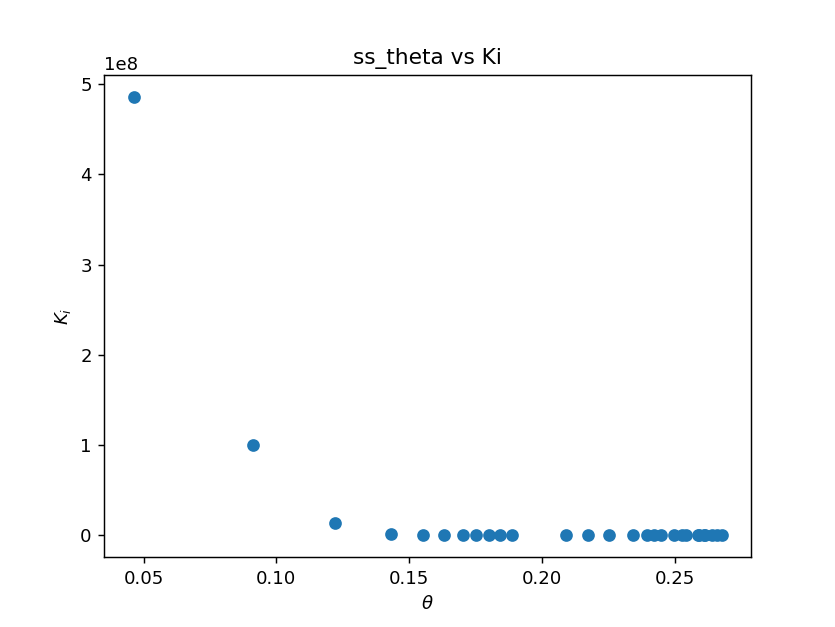

Text(0.5, 0, '$\\theta$')

In [10]:
plt.figure(dpi = 100)
plt.title('ss_theta vs Ki')
plt.scatter(df['theta'], df['Ki'])
plt.ylabel(r'$K_i$')
plt.xlabel(r'$\theta$')

In [11]:
X = df[['theta']]
y = df['Ki']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22, 1), (6, 1), (22,), (6,))

In [24]:
from gplearn.functions import make_function

def exp(x1):
    f = np.exp(x1)
    return f

def pow_2(x1):
    f = x1**2
    return f

def pow_3(x1):
    f = x1**3
    return f

exp = make_function(function=exp,name='exp',arity=1)
pow_2 = make_function(function=pow_2,name='pow2',arity=1)# add the new function to the function_set
pow_3 = make_function(function=pow_3,name='pow3',arity=1)# add the new function to the function_set

function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg','inv',exp, pow_2,pow_3]



In [25]:
est_gp = SymbolicRegressor(population_size=500000,function_set=function_set,const_range=(0.0,0.0),
                           generations=20, stopping_criteria=0.01,metric='rmse',
                           p_crossover=0.85, p_subtree_mutation=0.05, ##
                           p_hoist_mutation=0.05, p_point_mutation=0.05, ##need to add up to 1
                           max_samples=0.8, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

In [ ]:
t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_6954/4049802405.py:4: RuntimeWarning: overflow encountered in exp
  f = np.exp(x1)
/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_6954/4049802405.py:12: RuntimeWarning: overflow encountered in power
  f = x1**3
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/fitness.py:137: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.average(((y_pred - y) ** 2), weights=w))
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:527: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:46: RuntimeWarning: invalid value encountered in sin
  return self.function(*args)
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:46: RuntimeWarning: invalid value encountered in multiply
  return self.function(

   0    11.49              nan        5              nan              nan     61.45m


/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:46: RuntimeWarning: invalid value encountered in add
  return self.function(*args)


   1    11.44              nan       19              nan              nan     69.94m
   2    14.49              nan       54              nan              nan     66.89m
   3    21.56              nan       14              nan              nan     70.39m
   4    25.26              nan       33              nan              nan     75.42m
   5    28.79              nan        8              nan              nan     75.56m
   6    32.29              nan       14              nan              nan     74.08m
   7    35.86              nan       48              nan              nan     79.33m
   8    39.52              nan       29              nan              nan     73.66m
   9    43.17              nan       14              nan              nan     72.34m


/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


  10    47.01              nan       46              nan              nan     84.42m


/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:46: RuntimeWarning: overflow encountered in subtract
  return self.function(*args)


  11    50.85              nan       71              nan              nan     78.92m
  12    54.86              nan       35              nan              nan     77.72m
  13    59.01              nan       89              nan              nan     68.02m
  14    63.29              nan       43              nan              nan    210.09m


In [ ]:
t0 = time.time()
y_gp1 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

In [ ]:
score_gp1 = est_gp.score(X_test, y_test)
print('R2:', score_gp1)

In [ ]:
converter = {
    'add': lambda x, y : x + y,
    'sub': lambda x, y : x - y,
    'mul': lambda x, y : x*y,
    'div': lambda x, y : x/y,
    'sqrt': lambda x : x**0.5,
    'log': lambda x : log(x),
    'abs': lambda x : abs(x),
    'neg': lambda x : -x,
    'inv': lambda x : 1/x,
    'max': lambda x, y : max(x, y),
    'min': lambda x, y : min(x, y),
    'sin': lambda x : sin(x),
    'cos': lambda x : cos(x),
    'pow': lambda x, y : x**y,
}

In [ ]:
next_e = sympify(str(est_gp._program), locals=converter)
next_e

In [ ]:
y_gp = est_gp.predict(X_test)
score_gp1 = est_gp.score(X_test, y_test)
score_gp1

In [ ]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_gp1, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_gp1/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

In [ ]:
##Step4: Ret#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [ ]:
%%time
#Performing SS MIKI MKM simulations for lateral case
from main import *
MKMCD = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKMCD.Thermo_Constraint = 'OFF'
MKMCD.set_limits_of_integration(t0,tf)
colmn = len(MKMCD.Stoich.iloc[0,1:]) - len(MKMCD.P) #Number of columns (i.e rate coefficients = no. of surface species being investigated)
row = len(MKMCD.k) #number of rows = number of rate constants (i.e reaction steps)
MKM_SS_covg_LAT = []
Prs = Prs_lat #Lateral pressures## TO BE PREDICTED###########################################################
for i in np.arange(len(Prs)):
    MKMCD.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKMCD.get_SS_coverages(print_warning=True)[0])    

In [ ]:
##Step 4-> Getting predicted _f(theta)
Ki_lateral_pred = est_gp.predict(np.array([MKM_SS_covg_LAT]).T)

##Step6-> Calculating predicted theta
ML_theta_pred = []
for i in np.arange(len(Prs)):
    ML_theta_pred.append((Ki_lateral_pred[i]*Prs[i])/(1+(Ki_lateral_pred[i]*Prs[i])))

In [ ]:
plt.figure()
plt.semilogx(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

In [ ]:
plt.figure()
plt.plot(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.plot(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()